# Predicting Human Activity Using Smartphone Data

I want to be able to predict how people are moving based on data collection from their smart phones. 

I will be using data from the Human Activity Recognition database which was made from the study of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, 3-axial linear acceleration and 3-axial angular velocity were captured at a constant rate of 50Hz (every 0.02 seconds). Readings were then averaged over a second's length of time. The experiments were also video-recorded and the outcome was labeled manually. 

The dataset has already been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data.

In [1]:
import pandas as pd
import numpy as np
import scipy
import random
import time
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import rgb2hex
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import statsmodels.formula.api as smf
import sklearn
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

## Importing the Data

I must first make sure my data is clean and ready to be worked with.

In [61]:
train = pd.read_csv('C:\\Code\\Data\\human-activity-recognition-with-smartphones\\train.csv')
test = pd.read_csv('C:\\Code\\Data\\human-activity-recognition-with-smartphones\\test.csv')

In [62]:
#check for null values
print('Are there any null values in the training set?')
print(train.isnull().values.any())
print('\nAre there any null values in the testing set?')
print(test.isnull().values.any())

Are there any null values in the training set?
False

Are there any null values in the testing set?
False


In [4]:
#create dataframe containing both training and testing 
train['Data'] = 'Train'
test['Data'] = 'Test'
both = pd.concat([train, test], axis=0).reset_index(drop=True)
both['subject_str'] = '#' + both['subject'].astype(str)

train = train.drop('Data',1)
test = test.drop('Data',1)

both_df = both.drop(['Activity','subject'],1)

I'll take a look at the shape a head of each data frame

In [6]:
print('Training Set')
print('\nShape:')
print(train.shape)
print('\nFirst 5 Rows of the Training Set:')
display(train.head())

Training Set

Shape:
(7352, 563)

First 5 Rows of the Training Set:


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [7]:
print('Testing Set')
print('\nShape:')
print(test.shape)
print('\nFirst 5 Rows of the Testing Set:')
display(test.head())

Testing Set

Shape:
(2947, 563)

First 5 Rows of the Testing Set:


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,2,STANDING
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,2,STANDING
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,2,STANDING


Both data sets have 563 features, with only one of them being the outcome feature, "Activity", which is the manual label put to each activity. Also, as discussed earlier, the training and test set do indeed have a 70/30 split. 

I will now initiated my data tests for furuther manipulation. Along with the outcome variable Activity, I will also drop the subject number column from my data. As I am trying to predict actions done by any human, it should by irrelevent who did them.

In [64]:
#initiate train and testing features and outcomes
Xtrain = train.drop(['Activity','subject'],1)
Ytrain = train.Activity

Xtest = test.drop(['Activity','subject'],1)
Ytest = test.Activity

## Research questions:

1. Are there any errorneous values in the data set such as blanks or erroneous characters
2. Are the column labels unique? Are the labels of the training and test set identical?
3. Is the training data set balanced?
4. Are there any duplicate columns in the training and testing data?

### Erroneous Values


Since all of the data should be numbers between -1 and 1, with the exception of the outcome variable, I can check for erroneous data values by making sure all of my non-outcome features are a numeric variable type, or can be converted to one

In [9]:
display(Xtrain.describe())

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.250994,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.023692,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,0.134000,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,0.289096,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000


In [10]:
# show the count values of the describe function of Xtrain
print('Training Counts:')
display(Xtrain.describe().loc['count',:].value_counts())

# show the count values of the describe function of Xtrain
print('Testing Counts:')
display(Xtrain.describe().loc['count',:].value_counts())

Training Counts:


7352.0    561
Name: count, dtype: int64

Testing Counts:


7352.0    561
Name: count, dtype: int64

In [11]:
print('Summary of Training Variable Data Types\n')
print(Xtrain.dtypes.value_counts())
print('\nSummary of Testing Variable Data Types\n')
print(Xtest.dtypes.value_counts())

Summary of Training Variable Data Types

float64    561
dtype: int64

Summary of Testing Variable Data Types

float64    561
dtype: int64


All my variables have the same count (the number of rows in their respective data frame) when calling the describe function.  Additionally, each feature variable is the float type, meaning every variable must be a numberic values. Thus, I can conlcude that I do not have any variables or datapoints of erroneous type.

### Duplicate Column Names

Now I will see if I have a columns that share the same label, and correct them. 

In [12]:
print('Original Number of Training Features:')
print(Xtrain.shape[1])
print('\nOriginal Number of Testing Features:')
print(Xtest.shape[1])
#look at the columns names in training set
Xsettrain = set(Xtrain.columns)
print('\nNumber of Non-duplicate Name Training Features:')
print(len(Xsettrain))
#look at the columns names in testing set
Xsettest = set(Xtest.columns)
print('\nNumber of Non-duplicate Name Testing Features:')
print(len(Xsettest))
print('\nSet of difference in the training and testing sets:')
print(Xsettrain.symmetric_difference(Xsettest))

Original Number of Training Features:
561

Original Number of Testing Features:
561

Number of Non-duplicate Name Training Features:
561

Number of Non-duplicate Name Testing Features:
561

Set of difference in the training and testing sets:
set()


Both the training an the testing set have the same number of features and all their feature names are unique.

### Balanced Outcome

From here, I must make sure that my outcome is balanced, which can lead to serious problems when modeling if untrue.

In [13]:
# look at the outcome categories for training
print('Relative Fraction of the Outcome Training Variable')
print(round(train.Activity.value_counts()/train.shape[0],4))

Relative Fraction of the Outcome Training Variable
LAYING                0.1914
STANDING              0.1869
SITTING               0.1749
WALKING               0.1668
WALKING_UPSTAIRS      0.1459
WALKING_DOWNSTAIRS    0.1341
Name: Activity, dtype: float64


In [15]:
label = train.Activity
# Plotting data
label_counts = label.value_counts()

# Get colors
n = label_counts.shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Create plot
data = go.Bar(x = label_counts.index,
              y = label_counts,
              marker = dict(color = colors))

layout = go.Layout(title = 'Smartphone Activity Label Distribution Amoung The Training Set',
                   xaxis = dict(title = 'Activity'),
                   yaxis = dict(title = 'Count'))

fig = go.Figure(data=[data], layout=layout)
iplot(fig)

In [14]:
# look at the outcome categories for testing
print('Relative Fraction of the Outcome Testing Variable')
print(round(test.Activity.value_counts()/test.shape[0],4))

Relative Fraction of the Outcome Testing Variable
LAYING                0.1822
STANDING              0.1805
WALKING               0.1683
SITTING               0.1666
WALKING_UPSTAIRS      0.1598
WALKING_DOWNSTAIRS    0.1425
Name: Activity, dtype: float64


In [16]:
label = test.Activity
# Plotting data
label_counts = label.value_counts()

# Get colors
n = label_counts.shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Create plot
data = go.Bar(x = label_counts.index,
              y = label_counts,
              marker = dict(color = colors))

layout = go.Layout(title = 'Smartphone Activity Label Distribution Amoung The Testing Set',
                   xaxis = dict(title = 'Activity'),
                   yaxis = dict(title = 'Count'))

fig = go.Figure(data=[data], layout=layout)
iplot(fig)

There are 6 outcome activities: Laying, Sitting, Standing, Walking, Walking_Downstairs, and Walking_Upstairs. These Activities can be broadly put into 2 different categories, passive activities (laying, sitting, and standing) and active activities (walking, walking_upstairs, and walking_downstairs)

The outcome class is fairly balanced in the training, which will be very good for my model. It is also balanced in the testing set, but that is not nearly as important.

Now that I know the data is workable, I can begin doing more advanced manipulation. I know that my data set has a very large amount of features, which will make modleing computationally inefficient and prone to overfitting. My primary goal now is to remove extraneous features from my data.

# Data Exploration

I want to explore my data and see if there are any important trends I should be aware of.

In [17]:
both_tab = pd.crosstab(both.subject, both.Activity)

display(both_tab)

Activity,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
subject,,,,,,
1,50,47,53,95,49,53
2,48,46,54,59,47,48
3,62,52,61,58,49,59
4,54,50,56,60,45,52
5,52,44,56,56,47,47
6,57,55,57,57,48,51
7,52,48,53,57,47,51
8,54,46,54,48,38,41
9,50,50,45,52,42,49


So the number of activity readings are different for each person.  This indicates that each subject took a different amount of time to perform each action. If this is true, tha each person has there own unique style of movement, which makes sense.  I want to check and see if every erson does indeed take a unique amount of time to perform each action. Since each data point represents 1 second of action, I can use the amount of data points to tell me for how long that action was taken. 

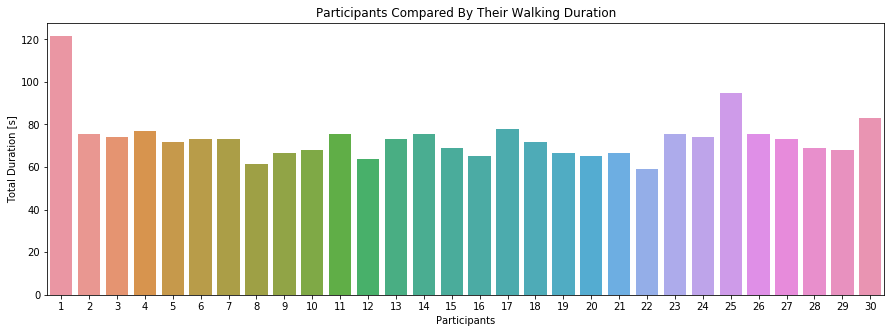

In [22]:
label = both.Activity
# Group the data by participant and compute total duration of walking
mask = label=='WALKING'
duration_df = (both[mask].groupby('subject')['Data'].count() * 1.28)

# Create plot
plot_data = duration_df.reset_index().sort_values('Data', ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(data=plot_data, x='subject', y='Data')
plt.title('Participants Compared By Their Walking Duration')
plt.xlabel('Participants')
plt.ylabel('Total Duration [s]')
plt.show()

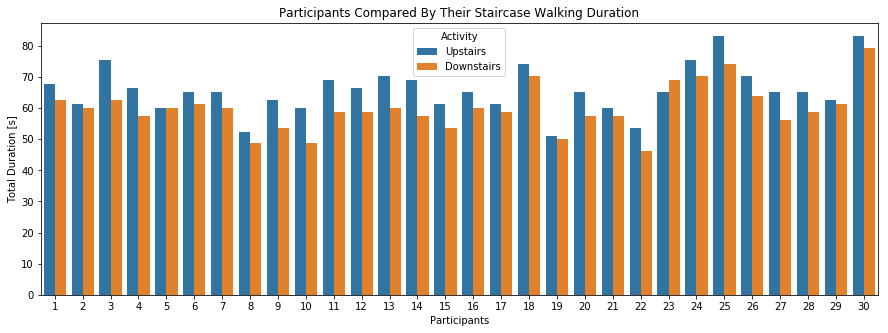

In [23]:
# Group the data by participant and compute total duration of staircase walking
mask = label.isin(['WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])
duration = (both[mask].groupby([label[mask], 'subject'])['Data'].count() * 1.28)

# Create plot
plot_data = duration.reset_index().sort_values('Data', ascending=False)
plot_data['Activity'] = plot_data['Activity'].map({'WALKING_UPSTAIRS':'Upstairs', 'WALKING_DOWNSTAIRS':'Downstairs'})

plt.figure(figsize=(15,5))
sns.barplot(data=plot_data, x='subject', y='Data', hue='Activity')
plt.title('Participants Compared By Their Staircase Walking Duration')
plt.xlabel('Participants')
plt.ylabel('Total Duration [s]')
plt.show()

So each person does indeed have their own walking style, shown in how differently each participant walked up and down the stairs. This could pose a problem for modeling, since I do not want the subject performing the action to be a feature. Since they are only 30 different participants to start with, and even less in the training data, too much variance in the training data could allow the model to recognize each different participants walking style and model using that. 

This is not in the spirit of the activity detection I would like to perform, I want my model to be avble to interperet anyone's movement without prior data.

Another thing I became curious about while exploring the data was the differences between the data for "passive" activities and "active" activities.  In the context of this experiment, passive actions including standing, sitting, and laying, while active actions include walking, walking upstairs, and walking downstairs.

I graphed the 2 main sensors inputs, the 't-body' and 'f-body' sensors, for each of the 6 activities across all data instances. 

The graphs are as follows: t-body maximum acceleration, t-body standard deviation of acceleration, f-body maximum acceleration, and f-body standard deviation of acceleration.

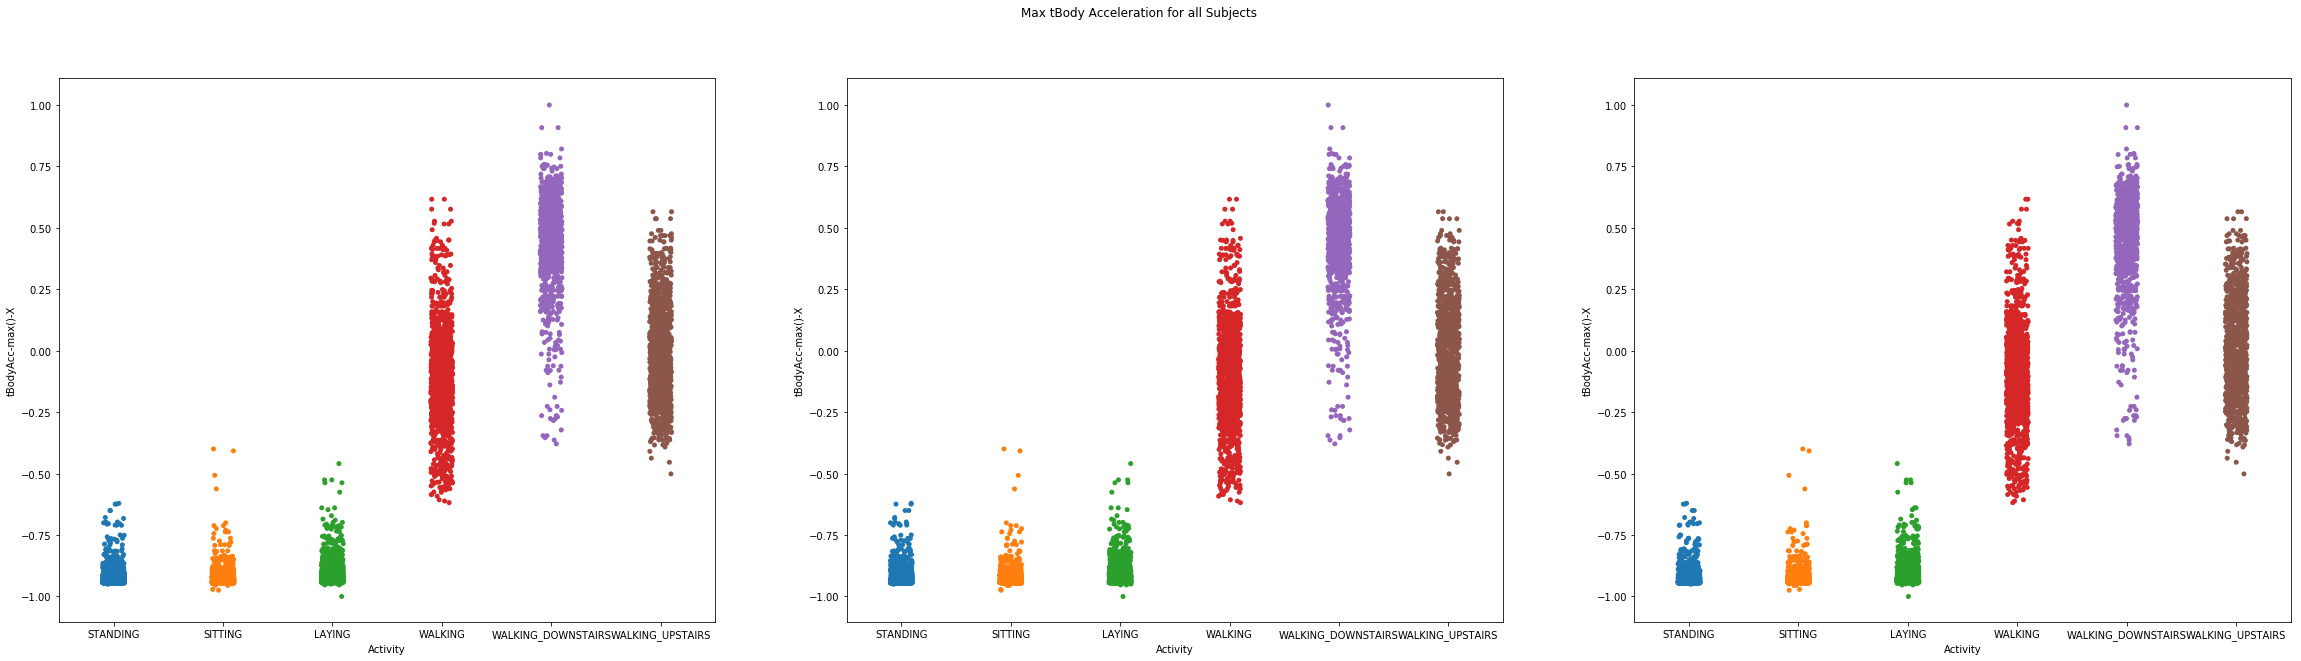

In [18]:
fig = plt.figure(figsize=(40,10))
ax1 = fig.add_subplot(131)
ax1 = sns.stripplot(x='Activity', y='tBodyAcc-max()-X', data=train, jitter=True)
ax2 = fig.add_subplot(132)
ax2 = sns.stripplot(x='Activity', y='tBodyAcc-max()-X', data=train, jitter=True)
ax3 = fig.add_subplot(133)
ax3 = sns.stripplot(x='Activity', y='tBodyAcc-max()-X', data=train, jitter=True)
plt.suptitle('Max tBody Acceleration for all Subjects')
plt.show()

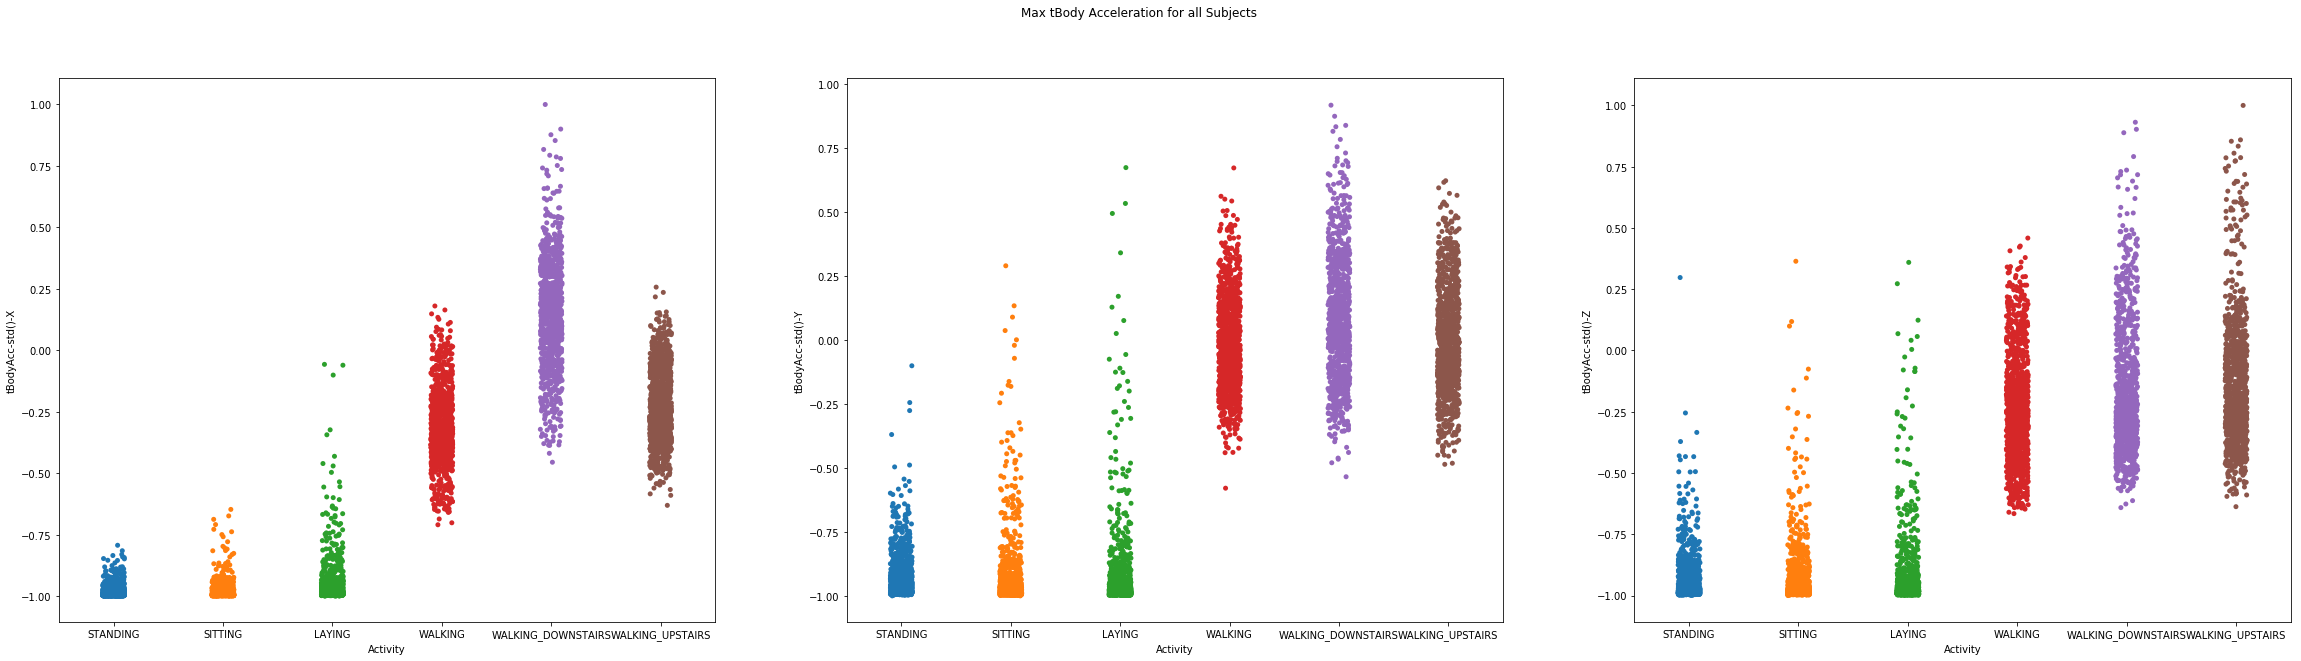

In [19]:
fig = plt.figure(figsize=(40,10))
ax1 = fig.add_subplot(131)
ax1 = sns.stripplot(x='Activity', y='tBodyAcc-std()-X', data=train, jitter=True)
ax2 = fig.add_subplot(132)
ax2 = sns.stripplot(x='Activity', y='tBodyAcc-std()-Y', data=train, jitter=True)
ax3 = fig.add_subplot(133)
ax3 = sns.stripplot(x='Activity', y='tBodyAcc-std()-Z', data=train, jitter=True)
plt.suptitle('Max tBody Acceleration for all Subjects')
plt.show()

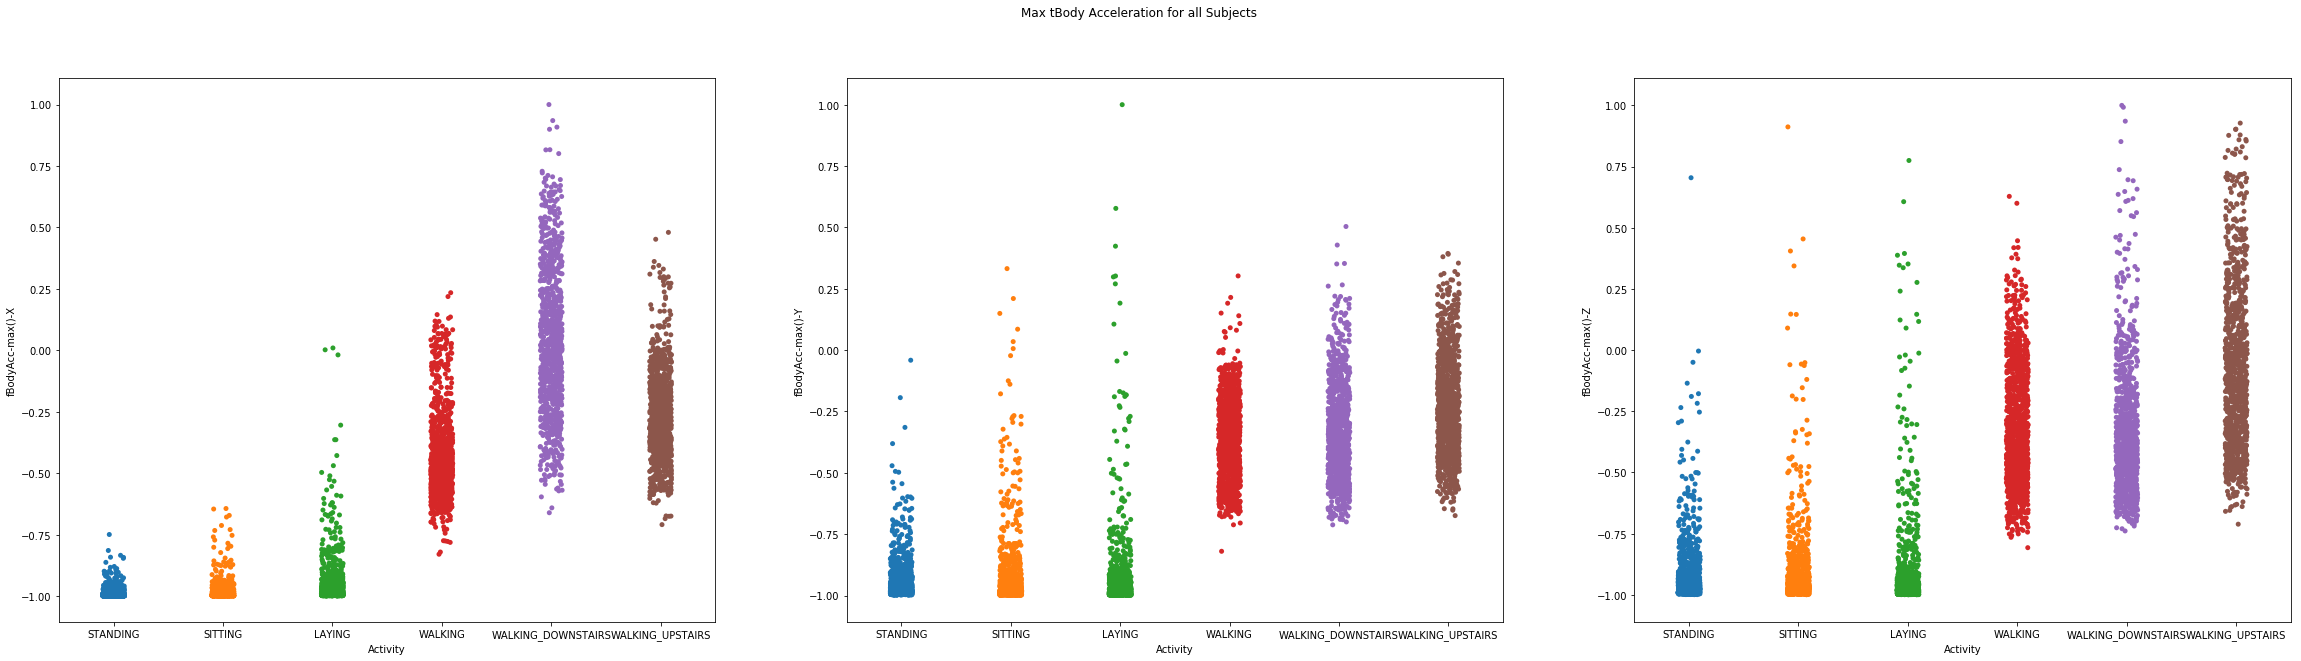

In [20]:
fig = plt.figure(figsize=(40,10))
ax1 = fig.add_subplot(131)
ax1 = sns.stripplot(x='Activity', y='fBodyAcc-max()-X', data=train, jitter=True)
ax2 = fig.add_subplot(132)
ax2 = sns.stripplot(x='Activity', y='fBodyAcc-max()-Y', data=train, jitter=True)
ax3 = fig.add_subplot(133)
ax3 = sns.stripplot(x='Activity', y='fBodyAcc-max()-Z', data=train, jitter=True)
plt.suptitle('Max tBody Acceleration for all Subjects')
plt.show()

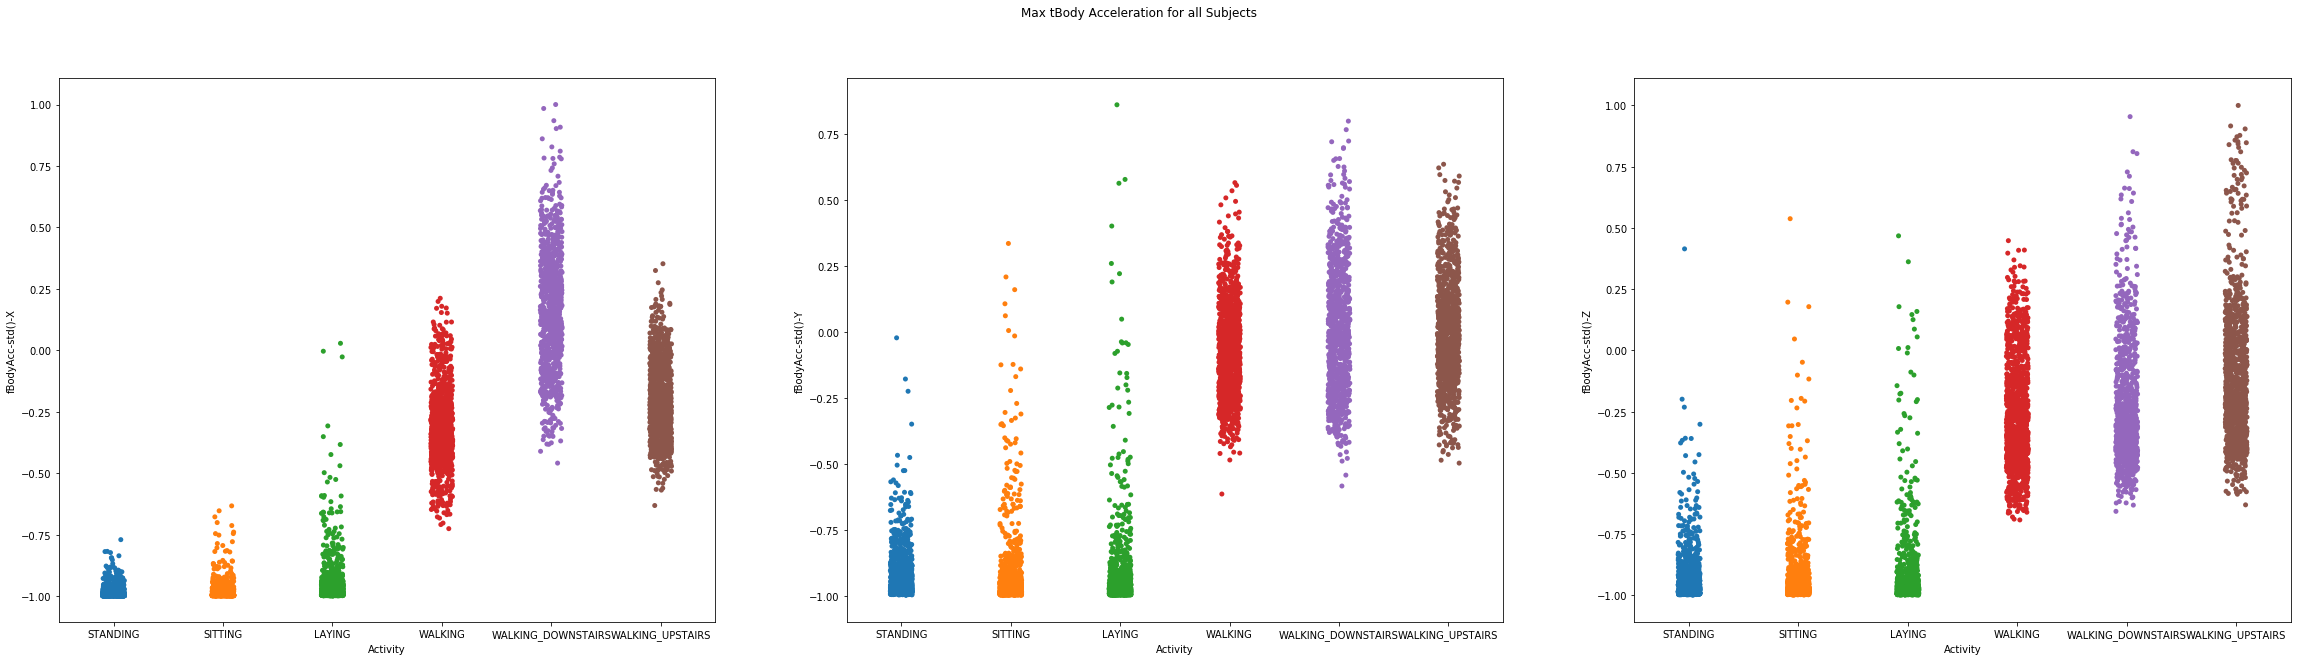

In [21]:
fig = plt.figure(figsize=(40,10))
ax1 = fig.add_subplot(131)
ax1 = sns.stripplot(x='Activity', y='fBodyAcc-std()-X', data=train, jitter=True)
ax2 = fig.add_subplot(132)
ax2 = sns.stripplot(x='Activity', y='fBodyAcc-std()-Y', data=train, jitter=True)
ax3 = fig.add_subplot(133)
ax3 = sns.stripplot(x='Activity', y='fBodyAcc-std()-Z', data=train, jitter=True)
plt.suptitle('Max tBody Acceleration for all Subjects')
plt.show()

I can see that my intuition was true and the passive and active activities really do form 2 distinct groups. The passive activities have much more clustered data, while the active activities have much more variable data. Additionally, the passive and active groups just have very similar looking distributions in general.

This could pose a problem to our model because it may be hard for the model to tell the difference between 2 different passive activities or 2 different active ones. This will especially be a problem if the data has too much noise.

# Feature Improvement

When exploring my data, I noticed a common trend: modeling my data is going to be very difficult if it has too much variance or noise. I will need to reduce feature dimensionality to create a successful model. 

Before I begin, I will determine the relative importance of the features, using the Random Forest model. If I need to choose between features, I can use the calculated feature importance to choose which one to keep. 

## Feature questions:

1. Are any features unimportant?
2. What number of features will give me ideal efficiency?
3. How important are feature selection techniques?

In [65]:
importances = pd.DataFrame()

In [66]:
rfc = ensemble.RandomForestClassifier(random_state=3)

rfc.fit(Xtrain,Ytrain)

Ypredrfc = rfc.predict(Xtest)

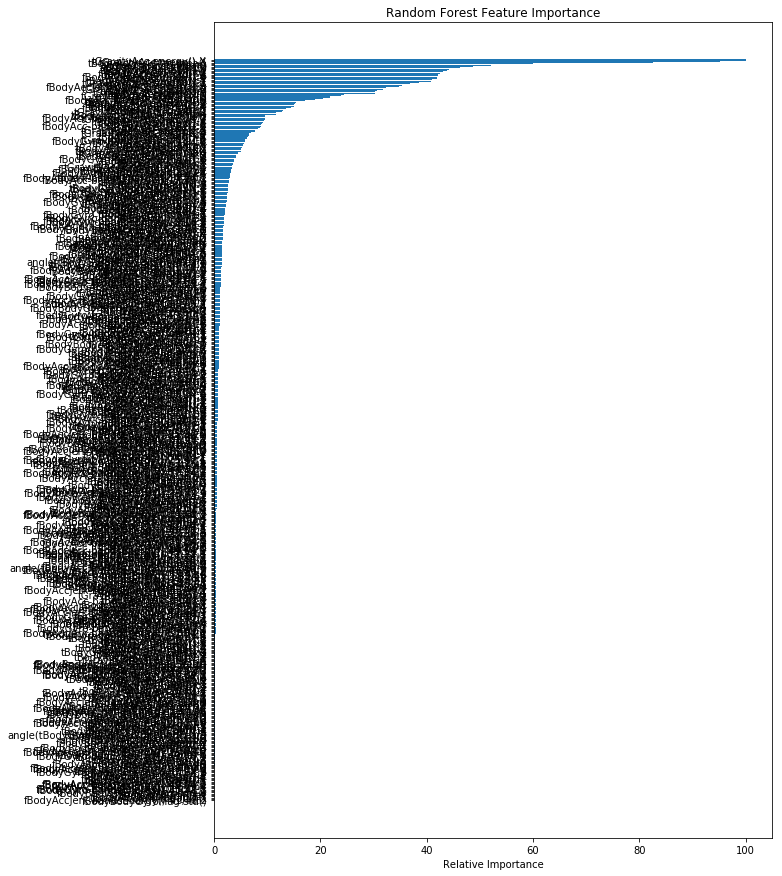

In [26]:
feature_importance = rfc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,15))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, Xtrain.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Random Forest Feature Importance')
plt.show()

importances['Names'] = list(Xtrain.columns[sorted_idx])
importances['Imp'] = list(feature_importance[sorted_idx])

## Remove Highly Correlating Features

The first method I will use to narrow down the number of features is determing which features are highly correlated. If 2 features share a particularly strong corralation, they are very likely to be explaining the same amount of variance with in the model, leading to overfitting and prediction errors. 

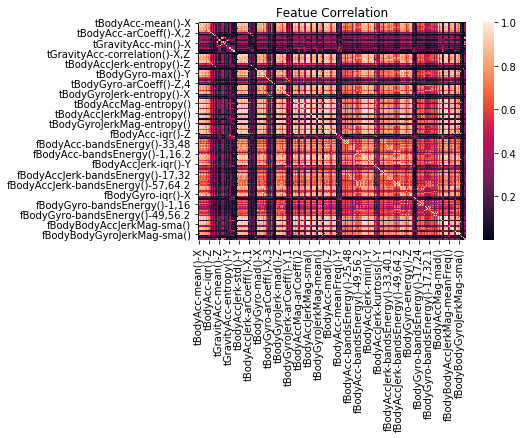

In [28]:
Xcorr = Xtrain.corr()

sns.heatmap(abs(Xcorr))
plt.title('Featue Correlation')
plt.show()

In [29]:
highcorr = pd.DataFrame()
# find high correlation features
corr_feat1 = []
corr_feat2 = []
for i in range(561):
    for x in range (561):
        if x > i:
            if Xcorr.iloc[i,x]>=.8:
                corr_feat1.append(Xcorr.index[i]) 
                corr_feat2.append(Xcorr.columns[x])

highcorr['var1'] = corr_feat1
highcorr['var2'] = corr_feat2

In [30]:
print('There are ',highcorr.shape[0],' instances of highly correlated variables')
display(highcorr.head())

There are  20886  instances of highly correlated variables


,var1,var2
0,tBodyAcc-std()-X,tBodyAcc-std()-Y
1,tBodyAcc-std()-X,tBodyAcc-std()-Z
2,tBodyAcc-std()-X,tBodyAcc-mad()-X
3,tBodyAcc-std()-X,tBodyAcc-mad()-Y
4,tBodyAcc-std()-X,tBodyAcc-mad()-Z


In [31]:
# create set of duplicate removed features using RFC feature importance
del_var = []
for i in range(highcorr.shape[0]):
    a = str(highcorr['var1'][i])
    b = str(highcorr['var2'][i])
    a_i = float(importances.loc[importances['Names'] == a,'Imp'])
    b_i = float(importances.loc[importances['Names'] == b,'Imp'])
    if a_i > b_i:
        del_var.append(b)
    elif a_i < b_i:
        del_var.append(a)
        
Xtrain_cor = Xtrain.drop(del_var,1)
Xtest_cor = Xtest.drop(del_var,1)
display(Xtrain_cor.head())

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-min()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3",...,fBodyBodyGyroMag-skewness(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,0.814263,0.929294,-0.853011,0.359910,-0.058526,-0.224848,0.264106,...,0.586156,-1.000000,-0.074323,-0.298676,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,-0.058627
1,0.278419,-0.016411,-0.123520,0.822637,0.611627,-0.329549,0.284213,0.284595,-0.090963,0.294310,...,-0.336310,-1.000000,0.158075,-0.595051,0.053477,-0.007435,-0.732626,0.703511,-0.844788,-0.054317
2,0.279653,-0.019467,-0.113462,0.839344,0.273025,-0.086309,0.337202,-0.164739,-0.074507,0.342256,...,-0.535352,-0.555556,0.414503,-0.390748,-0.118559,0.177899,0.100699,0.808529,-0.848933,-0.049118
3,0.279174,-0.026201,-0.123283,0.837869,0.061436,0.074840,0.198204,-0.264307,-0.155320,0.323154,...,-0.230091,-0.936508,0.404573,-0.117290,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,-0.047663
4,0.276629,-0.016570,-0.115362,0.837869,0.313276,-0.131208,0.191161,0.086904,-0.272505,0.434728,...,-0.510282,-0.936508,0.087753,-0.351471,0.123320,0.122542,0.693578,-0.615971,-0.847865,-0.043892


In [32]:
#trying both models with both sets of variables
rfc = ensemble.RandomForestClassifier()

rfc.fit(Xtrain_cor,Ytrain)

print('Accuracy of Random Forest with RFC Determined Features')
print('\nTraing Accuracy:')
print(round(rfc.score(Xtrain_cor,Ytrain),4))
print('\nTesting Accuracy:')
print(round(rfc.score(Xtest_cor,Ytest),4))

Accuracy of Random Forest with RFC Determined Features

Traing Accuracy:
0.9997

Testing Accuracy:
0.8951


## Selecting From Model

In this feature set, I will use the sklearn module, SelectFromModel, to determine the most important features.  This module works by iteratively checking feature importances while it selects new features.

In [33]:
rfc = ensemble.RandomForestClassifier(random_state=3)

rfc = rfc.fit(Xtrain,Ytrain)
sel = SelectFromModel(rfc, prefit=True)
Xtrain_sel = sel.transform(Xtrain)
Xtest_sel = sel.transform(Xtest)
print('Number of Features:')
print(Xtest_sel.shape[1])

Number of Features:
77


## Keeping the Most Importance Features

This time, I will simply keep the 77 most important features.  I have done this intentionally to see how much better, if at all, the machine learning algorithm is at selecting features than manually selecting them. 

In [34]:
# create set most important features, determined by RFC
del_var = []
for i in importances['Names'][importances['Imp']>3.7]:
    del_var.append(i)
        
Xtrain_imp = Xtrain[del_var]
Xtest_imp = Xtest[del_var]
display(Xtrain_imp.head())

,tBodyGyroJerk-iqr()-X,fBodyGyro-max()-X,"fBodyGyro-bandsEnergy()-1,8",tBodyGyro-mad()-X,"tBodyAcc-correlation()-Y,Z",tBodyAccJerkMag-iqr(),"tGravityAcc-arCoeff()-Z,4",tGravityAcc-sma(),tBodyGyroJerk-entropy()-X,tBodyAccMag-mad(),...,fBodyAccJerk-std()-X,tBodyGyroJerk-sma(),tGravityAcc-mean()-Y,fBodyAcc-std()-X,"angle(X,gravityMean)",tGravityAcc-min()-Y,"angle(Y,gravityMean)",tBodyAccJerkMag-sma(),tGravityAcc-mean()-X,tGravityAcc-energy()-X
0,-0.992300,-0.980498,-0.999865,-0.984586,0.660790,-0.992934,0.991653,-0.375426,-0.589851,-0.957993,...,-0.995821,-0.994453,-0.140840,-0.995422,-0.841247,-0.123213,0.179941,-0.993306,0.963396,0.899469
1,-0.990742,-0.987354,-0.999851,-0.986890,0.579382,-0.993485,0.830464,-0.383430,-0.600945,-0.978247,...,-0.996652,-0.995298,-0.141551,-0.998680,-0.844788,-0.114893,0.180289,-0.991253,0.966561,0.907829
2,-0.987130,-0.972901,-0.999680,-0.974922,0.608900,-0.989984,0.728755,-0.401602,-0.543635,-0.988327,...,-0.991249,-0.993415,-0.142010,-0.996313,-0.848933,-0.114893,0.180637,-0.988531,0.966878,0.908668
3,-0.990909,-0.994518,-0.999964,-0.991589,0.507459,-0.991736,0.385263,-0.400278,-0.562031,-0.986431,...,-0.991378,-0.995496,-0.143976,-0.996312,-0.848649,-0.121336,0.181935,-0.993078,0.967615,0.910621
4,-0.994513,-0.987950,-0.999870,-0.986944,0.599213,-0.996846,0.240569,-0.400477,-0.617738,-0.991170,...,-0.996903,-0.995878,-0.148750,-0.998606,-0.847865,-0.121834,0.185151,-0.993480,0.968224,0.912235


# Running Models

Now that I have reduced the number of features, I will run my models to predcit the outcome.

Since I have multiple different feature reduced sets, I will run my model multiple times with the multiple different feature selected training and testing sets.

In [35]:
# initiate dataframe to hold model test scores
scores = pd.DataFrame()
scores['Type'] = ['Number of Features',
                  'Runtime (seconds)',
                  'Testing Score',
                  'Training Score'
                  ]

## Modeling Questions

1. Which set of features will work best at modeling the outcome? 
2. Which Model Works Best at Predicting the Data? 

## Random Forest

I will run the random forest model using both the features determined by random forest and the features determined by extra trees.  I will then compare how well each model did and show the feature importances of each set of features according to the random forest classifier.

### All Features

In [36]:
# testing all features
rfc_all = ensemble.RandomForestClassifier(random_state=3)

start = time.time()

rfc_all.fit(Xtrain,Ytrain)

cvscorerfc_all = cross_val_score(rfc_all,Xtrain,Ytrain,cv=5)

print('All Features:')
print('\nNumber of Features Used:')
print(Xtrain.shape[1])
print('\nTraining Accuracy Score:')
print(round(rfc_all.score(Xtrain,Ytrain),4))
print('\nTesting Accuracy Score:')
print(round(rfc_all.score(Xtest,Ytest),4))
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscorerfc_all.mean(),2),round(cvscorerfc_all.std()*2,2)))

end = time.time()
runtime_all = end - start

print('\nRuntime: ',round(runtime_all,2),' seconds')

All Features:

Number of Features Used:
561

Training Accuracy Score:
0.9996

Testing Accuracy Score:
0.8999

Cross Validation Score:
0.9% +/- 0.02%

Runtime:  6.93  seconds


In [37]:
vars_all = [ Xtrain.shape[1],
             runtime_all,
             rfc_all.score(Xtest,Ytest),
             rfc_all.score(Xtrain,Ytrain)   
           ]
scores['All'] = vars_all

### Highly Correalted Features Removed

In [38]:
# testing features determined by removing highly correated features
rfc_cor = ensemble.RandomForestClassifier(random_state=3)

start = time.time()

rfc_cor.fit(Xtrain_cor,Ytrain)

cvscorerfc_cor = cross_val_score(rfc_cor,Xtrain_cor,Ytrain,cv=5)

print('All Features:')
print('\nNumber of Features Used:')
print(Xtrain_cor.shape[1])
print('\nTraining Accuracy Score:')
print(round(rfc_cor.score(Xtrain_cor,Ytrain),4))
print('\nTesting Accuracy Score:')
print(round(rfc_cor.score(Xtest_cor,Ytest),4))
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscorerfc_cor.mean(),2),round(cvscorerfc_cor.std()*2,2)))

end = time.time()
runtime_cor = end - start

print('\nRuntime: ',round(runtime_cor,2),' seconds')

All Features:

Number of Features Used:
171

Training Accuracy Score:
0.9986

Testing Accuracy Score:
0.8935

Cross Validation Score:
0.89% +/- 0.06%

Runtime:  4.03  seconds


In [39]:
vars_cor = [ Xtrain_cor.shape[1],
             runtime_cor,
             rfc_cor.score(Xtest_cor,Ytest),
             rfc_cor.score(Xtrain_cor,Ytrain)  
           ]
scores['Correlation'] = vars_cor

### Selecting Features from the Model

In [40]:
# testing features determined by removing highly correated features
rfc_sel = ensemble.RandomForestClassifier(random_state=3)

start = time.time()

rfc_sel.fit(Xtrain_sel,Ytrain)

cvscorerfc_sel = cross_val_score(rfc_sel,Xtrain_sel,Ytrain,cv=5)

print('All Features:')
print('\nNumber of Features Used:')
print(Xtrain_sel.shape[1])
print('\nTraining Accuracy Score:')
print(round(rfc_sel.score(Xtrain_sel,Ytrain),4))
print('\nTesting Accuracy Score:')
print(round(rfc_sel.score(Xtest_sel,Ytest),4))
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscorerfc_sel.mean(),2),round(cvscorerfc_sel.std()*2,2)))

end = time.time()
runtime_sel = end - start

print('\nRuntime: ',round(runtime_sel,2),' seconds')

All Features:

Number of Features Used:
77

Training Accuracy Score:
0.9995

Testing Accuracy Score:
0.8904

Cross Validation Score:
0.9% +/- 0.03%

Runtime:  2.23  seconds


In [41]:
vars_sel = [ Xtrain_sel.shape[1],
             runtime_sel,
             rfc_sel.score(Xtest_sel,Ytest),
             rfc_sel.score(Xtrain_sel,Ytrain)  
           ]
scores['Selection'] = vars_sel

### Highest Feature Importance

In [42]:
# testing features determined by removing highly correated features
rfc_imp = ensemble.RandomForestClassifier(random_state=3)

start = time.time()

rfc_imp.fit(Xtrain_imp,Ytrain)

cvscorerfc_imp = cross_val_score(rfc_imp,Xtrain_imp,Ytrain,cv=5)

print('Importance:')
print('\nNumber of Features Used:')
print(Xtrain_imp.shape[1])
print('\nTraining Accuracy Score:')
print(round(rfc_imp.score(Xtrain_imp,Ytrain),4))
print('\nTesting Accuracy Score:')
print(round(rfc_imp.score(Xtest_imp,Ytest),4))
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscorerfc_imp.mean(),2),round(cvscorerfc_imp.std()*2,2)))

end = time.time()
runtime_imp = end - start

print('\nRuntime: ',round(runtime_imp,2),' seconds')

Importance:

Number of Features Used:
77

Training Accuracy Score:
0.9995

Testing Accuracy Score:
0.8768

Cross Validation Score:
0.89% +/- 0.05%

Runtime:  2.16  seconds


In [43]:
vars_imp = [ Xtrain_imp.shape[1],
             runtime_imp,
             rfc_imp.score(Xtest_imp,Ytest),
             rfc_imp.score(Xtrain_imp,Ytrain)  
           ]
scores['Importance'] = vars_imp

## Other Models

For consistency sake, I will model the other model types with only one feature set, the selection feature set. I chose this one becuase it had the highest testing accuracy in the random forest model while also striking the best balance between reduced dimensionality and conserved variance.

### Extra Trees Classifier

In [44]:
# testing features determined by removing highly correated features
etc = ensemble.ExtraTreesClassifier(random_state=3)

start = time.time()

etc.fit(Xtrain_sel,Ytrain)

cvscoreetc = cross_val_score(etc,Xtrain_sel,Ytrain,cv=5)

print('All Features:')
print('\nTraining Accuracy Score:')
print(round(etc.score(Xtrain_sel,Ytrain),4))
print('\nTesting Accuracy Score:')
print(round(etc.score(Xtest_sel,Ytest),4))
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscoreetc.mean(),2),round(cvscoreetc.std()*2,2)))

end = time.time()
runtime_etc = end - start

print('\nRuntime: ',round(runtime_etc,2),' seconds')

All Features:

Training Accuracy Score:
1.0

Testing Accuracy Score:
0.8887

Cross Validation Score:
0.91% +/- 0.03%

Runtime:  0.55  seconds


In [45]:
vars_etc = [ Xtrain_sel.shape[1],
             runtime_etc,
             etc.score(Xtest_sel,Ytest),
             etc.score(Xtrain_sel,Ytrain)  
           ]
scores['Xtra'] = vars_etc

### K Nearest Neighbors

In [46]:
# testing features determined by removing highly correated features
knn = neighbors.KNeighborsClassifier()

start = time.time()

knn.fit(Xtrain_sel,Ytrain)

cvscoreknn = cross_val_score(knn,Xtrain_sel,Ytrain,cv=5)

print('All Features:')
print('\nTraining Accuracy Score:')
print(round(knn.score(Xtrain_sel,Ytrain),4))
print('\nTesting Accuracy Score:')
print(round(knn.score(Xtest_sel,Ytest),4))
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscoreknn.mean(),2),round(cvscoreknn.std()*2,2)))

end = time.time()
runtime_knn = end - start

print('\nRuntime: ',round(runtime_knn,2),' seconds')

All Features:

Training Accuracy Score:
0.983

Testing Accuracy Score:
0.906

Cross Validation Score:
0.9% +/- 0.05%

Runtime:  8.11  seconds


In [47]:
vars_knn = [ Xtrain_sel.shape[1],
             runtime_knn,
             knn.score(Xtest_sel,Ytest),
             knn.score(Xtrain_sel,Ytrain)  
           ]
scores['KNN'] = vars_knn

### Support Vector Classifier

In [48]:
# testing features determined by removing highly correated features
svc = SVC(random_state=3)

start = time.time()

svc.fit(Xtrain_sel,Ytrain)

cvscoresvc = cross_val_score(svc,Xtrain_sel,Ytrain,cv=5)

print('All Features:')
print('\nTraining Accuracy Score:')
print(round(svc.score(Xtrain_sel,Ytrain),4))
print('\nTesting Accuracy Score:')
print(round(svc.score(Xtest_sel,Ytest),4))
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscoresvc.mean(),2),round(cvscoresvc.std()*2,2)))

end = time.time()
runtime_svc = end - start

print('\nRuntime: ',round(runtime_svc,2),' seconds')

All Features:

Training Accuracy Score:
0.946

Testing Accuracy Score:
0.9084

Cross Validation Score:
0.91% +/- 0.04%

Runtime:  9.02  seconds


In [49]:
vars_svc = [ Xtrain_sel.shape[1],
             runtime_svc,
             svc.score(Xtest_sel,Ytest),
             svc.score(Xtrain_sel,Ytrain)  
           ]
scores['SVC'] = vars_svc

### Lasso Logistic Regression

In [50]:
# testing features determined by removing highly correated features
lrl = linear_model.LogisticRegression(penalty='l1',random_state=3)

start = time.time()

lrl.fit(Xtrain_sel,Ytrain)

cvscorelrl = cross_val_score(lrl,Xtrain_sel,Ytrain,cv=5)

print('All Features:')
print('\nTraining Accuracy Score:')
print(round(lrl.score(Xtrain_sel,Ytrain),4))
print('\nTesting Accuracy Score:')
print(round(lrl.score(Xtest_sel,Ytest),4))
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscorelrl.mean(),2),round(cvscorelrl.std()*2,2)))

end = time.time()
runtime_lrl = end - start

print('\nRuntime: ',round(runtime_lrl,2),' seconds')

All Features:

Training Accuracy Score:
0.9655

Testing Accuracy Score:
0.9287

Cross Validation Score:
0.92% +/- 0.05%

Runtime:  39.91  seconds


In [51]:
vars_lrl = [ Xtrain_sel.shape[1],
             runtime_lrl,
             lrl.score(Xtest_sel,Ytest),
             lrl.score(Xtrain_sel,Ytrain)  
           ]
scores['Logistic'] = vars_lrl

# Conclusion

How did my feature sets and models perform?

In [52]:
display(scores)

,Type,All,Correlation,Selection,Importance,Xtra,KNN,SVC,Logistic
0,Number of Features,561.000000,171.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
1,Runtime (seconds),6.932497,4.030250,2.233017,2.157218,0.553724,8.110271,9.019869,39.913295
2,Testing Score,0.899898,0.893451,0.890397,0.876824,0.888700,0.906006,0.908381,0.928741
3,Training Score,0.999592,0.998640,0.999456,0.999456,1.000000,0.982998,0.946001,0.965452


This table has the results from both the different feature sets which trained the Random Forest Classifier and the additional models that were tested out.  The type column simple states what type of value is being looks at. The All, Correlation, Selection, and Importance column are the RFC models trained with the respective column name's feature set. Finally, the Xtra, KNN, SVC, and Logstic columns correspond with the Extra Trees Classifier, K Nearest Neighbors, Support Vector Classification, and Lasso Logistic Regression respectively. 

In order to better digest the results, I will look at my findings in 2 different sets, the RFC set (with different feature sets) and the Classification set (with different predictive models)

## RFC with Different Feature Sets

In [53]:
scores_rfc = scores.iloc[:,0:5]

In [54]:
scores_rfc.iloc[0,1:] = scores_rfc.iloc[0,1:] / scores_rfc.iloc[0,1:].max()
scores_rfc.iloc[1,1:] = scores_rfc.iloc[1,1:] / scores_rfc.iloc[1,1:].max()

display(scores_rfc)

,Type,All,Correlation,Selection,Importance
0,Number of Features,1.000000,0.304813,0.137255,0.137255
1,Runtime (seconds),1.000000,0.581356,0.322109,0.311175
2,Testing Score,0.899898,0.893451,0.890397,0.876824
3,Training Score,0.999592,0.998640,0.999456,0.999456


In [55]:
scores_rfc_plot = pd.melt(scores_rfc, id_vars='Type', var_name='Feature Determination', value_name='Value')

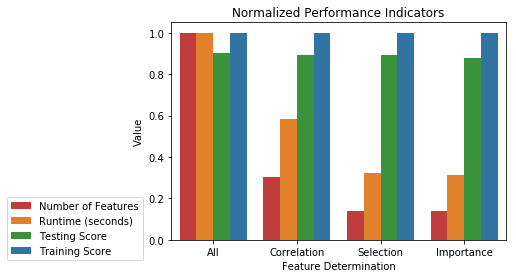

In [56]:
g = sns.barplot(x='Feature Determination', y='Value', data=scores_rfc_plot, hue='Type', palette=['C3','C1','C2','C0'])
plt.title('Normalized Performance Indicators')
g.legend(loc=1, bbox_to_anchor=(-0.07, .22))
plt.show()

How did changing the features set affect modeling?

Reducing the number of features drastically reduced overall runtime and thus increased efficiency. However, it also reduced training and testing accuracy. 

The best performing feature set overall was the selection feature set, I had nearly the lowest runtime (only a few fractions of  second longer than importance) while still keeping a very high accuracy. Since the goal of my feature dimentionality reduction was to imporve efficiency while still retaining most of the accuracy, the selection feature set accomplishes this the best. 

## Predicting with Different Models

In [57]:
scores_other = scores[['Type','Correlation','Xtra','KNN','SVC','Logistic']]
scores_other.columns = ['Type','RFC','Xtra','KNN','SVC','Logistic']

In [58]:
scores_other = scores_other.iloc[1:,:]
scores_other.iloc[0,1:] = scores_other.iloc[0,1:] / scores_other.iloc[0,1:].max()

display(scores_other)

,Type,RFC,Xtra,KNN,SVC,Logistic
1,Runtime (seconds),0.100975,0.013873,0.203197,0.225987,1.000000
2,Testing Score,0.893451,0.888700,0.906006,0.908381,0.928741
3,Training Score,0.998640,1.000000,0.982998,0.946001,0.965452


In [59]:
scores_other_plot = pd.melt(scores_other, id_vars='Type', var_name='Model Type', value_name='Value')

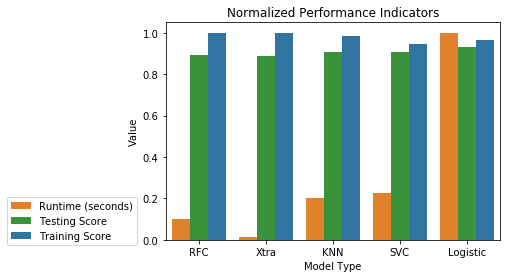

In [60]:
g = sns.barplot(x='Model Type', y='Value', data=scores_other_plot, hue='Type', palette=['C1','C2','C0'])
plt.title('Normalized Performance Indicators')
g.legend(loc=1, bbox_to_anchor=(-0.07, .22))
plt.show()

The Support Vector Classifier put out the best testing score, but also had a pretty high runtime. If accuracy was much more important that efficiency, I would use SVC.

The Random Forest Classifier put out the second best testing score and a very reasonable runtime. If accuracy and efficiency were equally as important, I would choose RFC.

The Extra Trees Classifier appears to have the serious problems given it's perfect training score but lowest testing score. It appears to be overfit with this data.

The K nearest Neighbors classifier also works very well, but is slightly outshined by the Support Vector Classifier. 

The Logistic Regressor did have the highest accuracy by far, which should not be ignored, but its poor Cross Validation results discourage further use. 

# References

https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones